In [1]:
from keras.applications import VGG16
from keras.models import load_model
from vis.utils import utils
from keras import activations

Using TensorFlow backend.


In [2]:
# Load our model
model = load_model('../datasets/bikes_classification_best.hdf5')
print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
__________

In [3]:
# Get the layer id we want to visualize from its name
layer_name = 'output'
layer_idx = utils.find_layer_idx(model, layer_name)
print(layer_idx)

22


In [4]:
import os
from keras.models import load_model

# Taken from vis package's util file and modified to work with Windows directory structure
def apply_modifications(model):
    """Applies modifications to the model layers to create a new Graph. For example, simply changing
    `model.layers[idx].activation = new activation` does not change the graph. The entire graph needs to be updated
    with modified inbound and outbound tensors because of change in layer building function.

    Args:
        model: The `keras.models.Model` instance.

    Returns:
        The modified model with changes applied. Does not mutate the original `model`.
    """
    # The strategy is to save the modified model and load it back. This is done because setting the activation
    # in a Keras layer doesnt actually change the graph. We have to iterate the entire graph and change the
    # layer inbound and outbound nodes with modified tensors. This is doubly complicated in Keras 2.x since
    # multiple inbound and outbound nodes are allowed with the Graph API.
    model_path = 'C:/Users/Richard/AppData/Local/Temp/temp.h5'
    try:
        model.save(model_path)
        return load_model(model_path)
    finally:
        os.remove(model_path)
        
# Swap softmax with linear
model.layers[layer_idx].activation = activations.linear
model = apply_modifications(model)

C:/Users/Richard/AppData/Local/Temp/temp.h5


# Visualize using Activation Maximization method

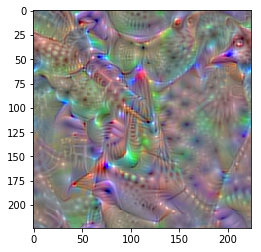

In [5]:
from vis.visualization import visualize_activation
from vis.input_modifiers import Jitter
from matplotlib import pyplot as plt
%matplotlib inline

# Change filter_indices to the output neuron you want to visualize
img = visualize_activation(model, layer_idx, filter_indices=3, max_iter=500, input_modifiers=[Jitter(16)])
plt.imshow(img)

Failed to lookup font 'FreeSans.ttf', falling back to default
Failed to lookup font 'FreeSans.ttf', falling back to default
Failed to lookup font 'FreeSans.ttf', falling back to default
Failed to lookup font 'FreeSans.ttf', falling back to default


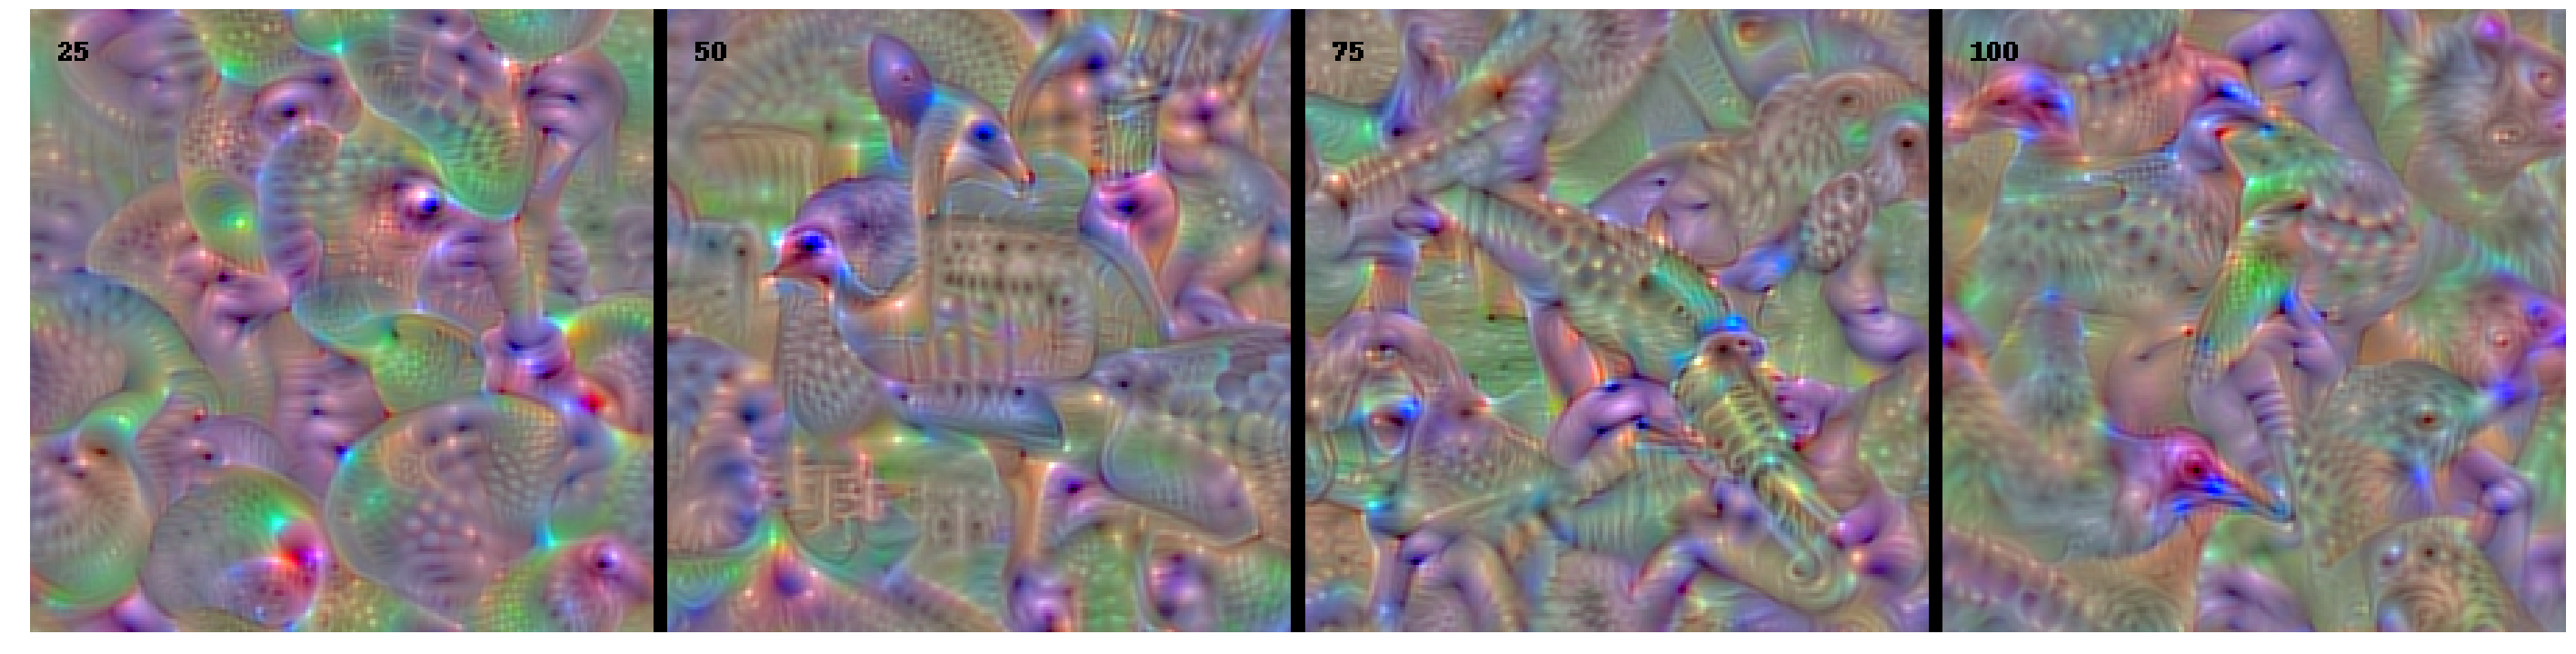

In [6]:
# Compile visualizations for all four classes that we have
vis_images = []
image_modifiers = [Jitter(16)]

for idx in [0,1,2,3]:    
    img = visualize_activation(model, layer_idx, filter_indices=idx, max_iter=500, input_modifiers=image_modifiers)
    img = utils.draw_text(img, str(idx*25+25))
    vis_images.append(img)

plt.rcParams['figure.figsize'] = (50, 50)
stitched = utils.stitch_images(vis_images)
plt.axis('off')
plt.imshow(stitched)
plt.show()

# Visualize saliency map and CAM

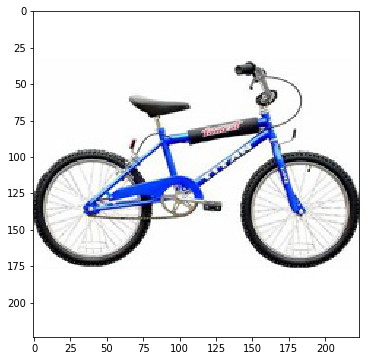

In [32]:
from vis.visualization import visualize_saliency, visualize_cam, overlay
from vis.utils import utils
from keras import activations

plt.rcParams['figure.figsize'] = (18, 6)

# Load a demo image to work with
img = utils.load_img('../datasets/demo36.jpg')
plt.imshow(img)

# Reshape it to work with VGG16
print(img.shape)
img = img.resize(3,224,224)

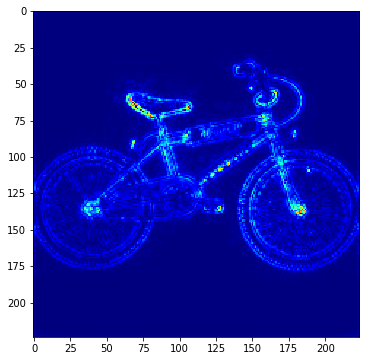

In [43]:
from vis.visualization import visualize_saliency, overlay
from vis.utils import utils
from keras import activations

plt.figure()
grads = visualize_saliency(model, layer_idx, filter_indices=0, seed_input=img, backprop_modifier='guided')
plt.imshow(grads, cmap='jet')

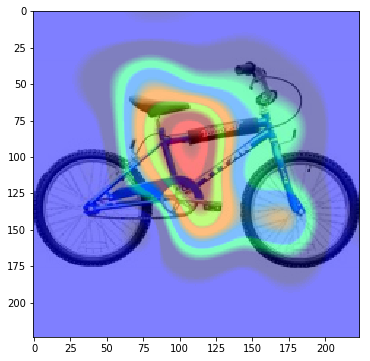

In [50]:
import numpy as np
import matplotlib.cm as cm

img = utils.load_img('../datasets/demo36.jpg')

plt.figure()
grads = visualize_cam(model, layer_idx, filter_indices=0, seed_input=img, backprop_modifier='guided')        

# Create heatmap and overlay it on the original pic  
jet_heatmap = np.uint8(cm.jet(grads)[..., :3] * 255)
plt.imshow(overlay(jet_heatmap[:,:,:,0], img))